# Jake Cupani
# INST414
# Final Project

# Detecting Radiation Events from the NASA GEDI Satellite

# Imports

In [221]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import numpy as np
import datetime
import seaborn as sn
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.style.use("ggplot")

# Data Collection & Manipulation

In [222]:
# In order to read in the HDF file, we need to use h5py
with h5py.File('GEDI01_A_2019214130032_O03613_T05061_02_003_01.h5', 'r') as f:    
    keys = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
    for key in keys:
        data = f[key]
        df_list = []
        sample_length = int(len(data['rx_sample_start_index'])/10)
        random_sample = random.sample(range(1, len(data['rx_sample_start_index'])), sample_length)

        for i in tqdmn(range(sample_length)):
            
            # Only get samples that are within our random sample
            if i not in random_sample:
                continue
            
            start = int(data['rx_sample_start_index'][i])-1
            sample_count = int(data['rx_sample_count'][i])
            
            # Select data from start index to start + sample_count since padded by zeroes
            sample = list(data['rxwaveform'][start:start+sample_count])

            df = pd.DataFrame()
            df['sample'] = sample
            df['start'] = [start] * len(sample)
            df['sample_count'] = [sample_count] * len(sample)

            df['dma_htr_i'] = [data['INST_HK']['dma_htr_i'][i]] * len(sample)
            df['dmb_htr_i'] = [data["INST_HK"]['dmb_htr_i'][i]] * len(sample)
            df['dma_det_t'] = [data['INST_HK']['dma_det_t'][i]] * len(sample)
            df['dmb_det_t'] = [data['INST_HK']['dmb_det_t'][i]] * len(sample)
            df['adc_t'] = [data['INST_HK']['adc_t'][i]] * len(sample)
            
            df['altitude_instrument'] = [data['geolocation']['altitude_instrument'][i]] * len(sample)
            df['latitude_instrument'] = [data['geolocation']['latitude_instrument'][i]] * len(sample)
            df['longitude_instrument'] = [data['geolocation']['longitude_instrument'][i]] * len(sample)
            
            
            df['solar_azimuth'] = [data['geolocation']['solar_azimuth'][i]] * len(sample)
            df['solar_elevation'] = [data['geolocation']['solar_elevation'][i]] * len(sample)
            
            surface_type = data['geolocation']['surface_type']
            df['surface_type_land'] = [surface_type[0][i]] * len(sample)
            df['surface_type_ocean'] = [surface_type[1][i]] * len(sample)
            df['surface_type_inland_water'] = [surface_type[3][i]] * len(sample)

            df['tide_earth'] = [data['geophys_corr']['tide_earth'][i]] * len(sample)
            df['tide_load'] = [data['geophys_corr']['tide_load'][i]] * len(sample)
            df['tide_ocean'] = [data['geophys_corr']['tide_ocean'][i]] * len(sample)


            df['noise_mean'] = [data['noise_mean'][i]] * len(sample)
            df['noise_std_dev'] = [data['noise_mean'][i]] * len(sample)
            
            df['gps_time'] = [data['gps_time'][i]] * len(sample)
            df['datetime'] = [time.ctime(i) for i in df['gps_time']]
            df['detector'] = [key] * len(sample)
            
            df_list.append(df)
        
    df = pd.concat(df_list)
    df = pd.get_dummies(dataset, columns=["key"])
    df = df.drop('key',axis=1)
    df['is_anomaly'] = np.where(df['sample'] > df['noise_mean'] + 4 * df['noise_std_dev'],1,0)
    
    df.to_csv("dataset_final.csv",index=False)
    print(df)

In [223]:
# In this case, I am just reading in the data I have collected from the previous cell to save time.
# This dataset can be found at: 
# https://drive.google.com/open?id=1iSes8WWyPxizxsKPjcvb_-FvZt5dZ8F1

dataset = pd.read_csv("dataset_final.csv")

# In order to flag the anomalies, we look for samples that are greater than 2 standard deviations away from the noise mean
dataset['is_anomaly'] = np.where(dataset['sample'] > dataset['noise_mean'] + 2 * dataset['noise_std_dev'],1,0)

# Create dummy variables for the key variable (detector) and drop original column
dataset = pd.get_dummies(dataset, columns=["key"])
dataset

,sample,start,sample_count,dma_htr_i,dmb_htr_i,dma_det_t,dmb_det_t,adc_t,altitude_instrument,latitude_instrument,...,datetime,is_anomaly,key_BEAM0000,key_BEAM0001,key_BEAM0010,key_BEAM0011,key_BEAM0101,key_BEAM0110,key_BEAM1000,key_BEAM1011
0,247,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
1,244,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
2,239,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
3,242,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
4,245,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
5,243,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
6,247,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
7,248,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
8,248,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
9,248,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0


# Data Explortation

In [224]:
# With the average noise mean at around 234, we can see the magnitude of the anomalies which are in the thousands.
# We can also see that there are only 98 anomolous data points, which we will address with class balancing.
print("Noise Mean")
print(dataset['noise_mean'].describe())
print()
print("Anomalous Data")
print(dataset['sample'][dataset['is_anomaly'] == 1].describe())

Noise Mean
count   13075414.00000
mean         234.21404
std           13.97808
min          204.06250
25%          227.75000
50%          240.68750
75%          245.18750
max          254.06250
Name: noise_mean, dtype: float64

Anomalous Data
count   3786.00000
mean     790.32488
std      260.77855
min      616.00000
25%      708.00000
50%      738.00000
75%      787.00000
max     4095.00000
Name: sample, dtype: float64


In [225]:
print("Rate of Anomalous Data")
print((len(dataset['sample'][dataset['is_anomaly'] == 1])/len(dataset['sample']))*100,"%")

Rate of Anomalous Data
0.028955106125129193 %


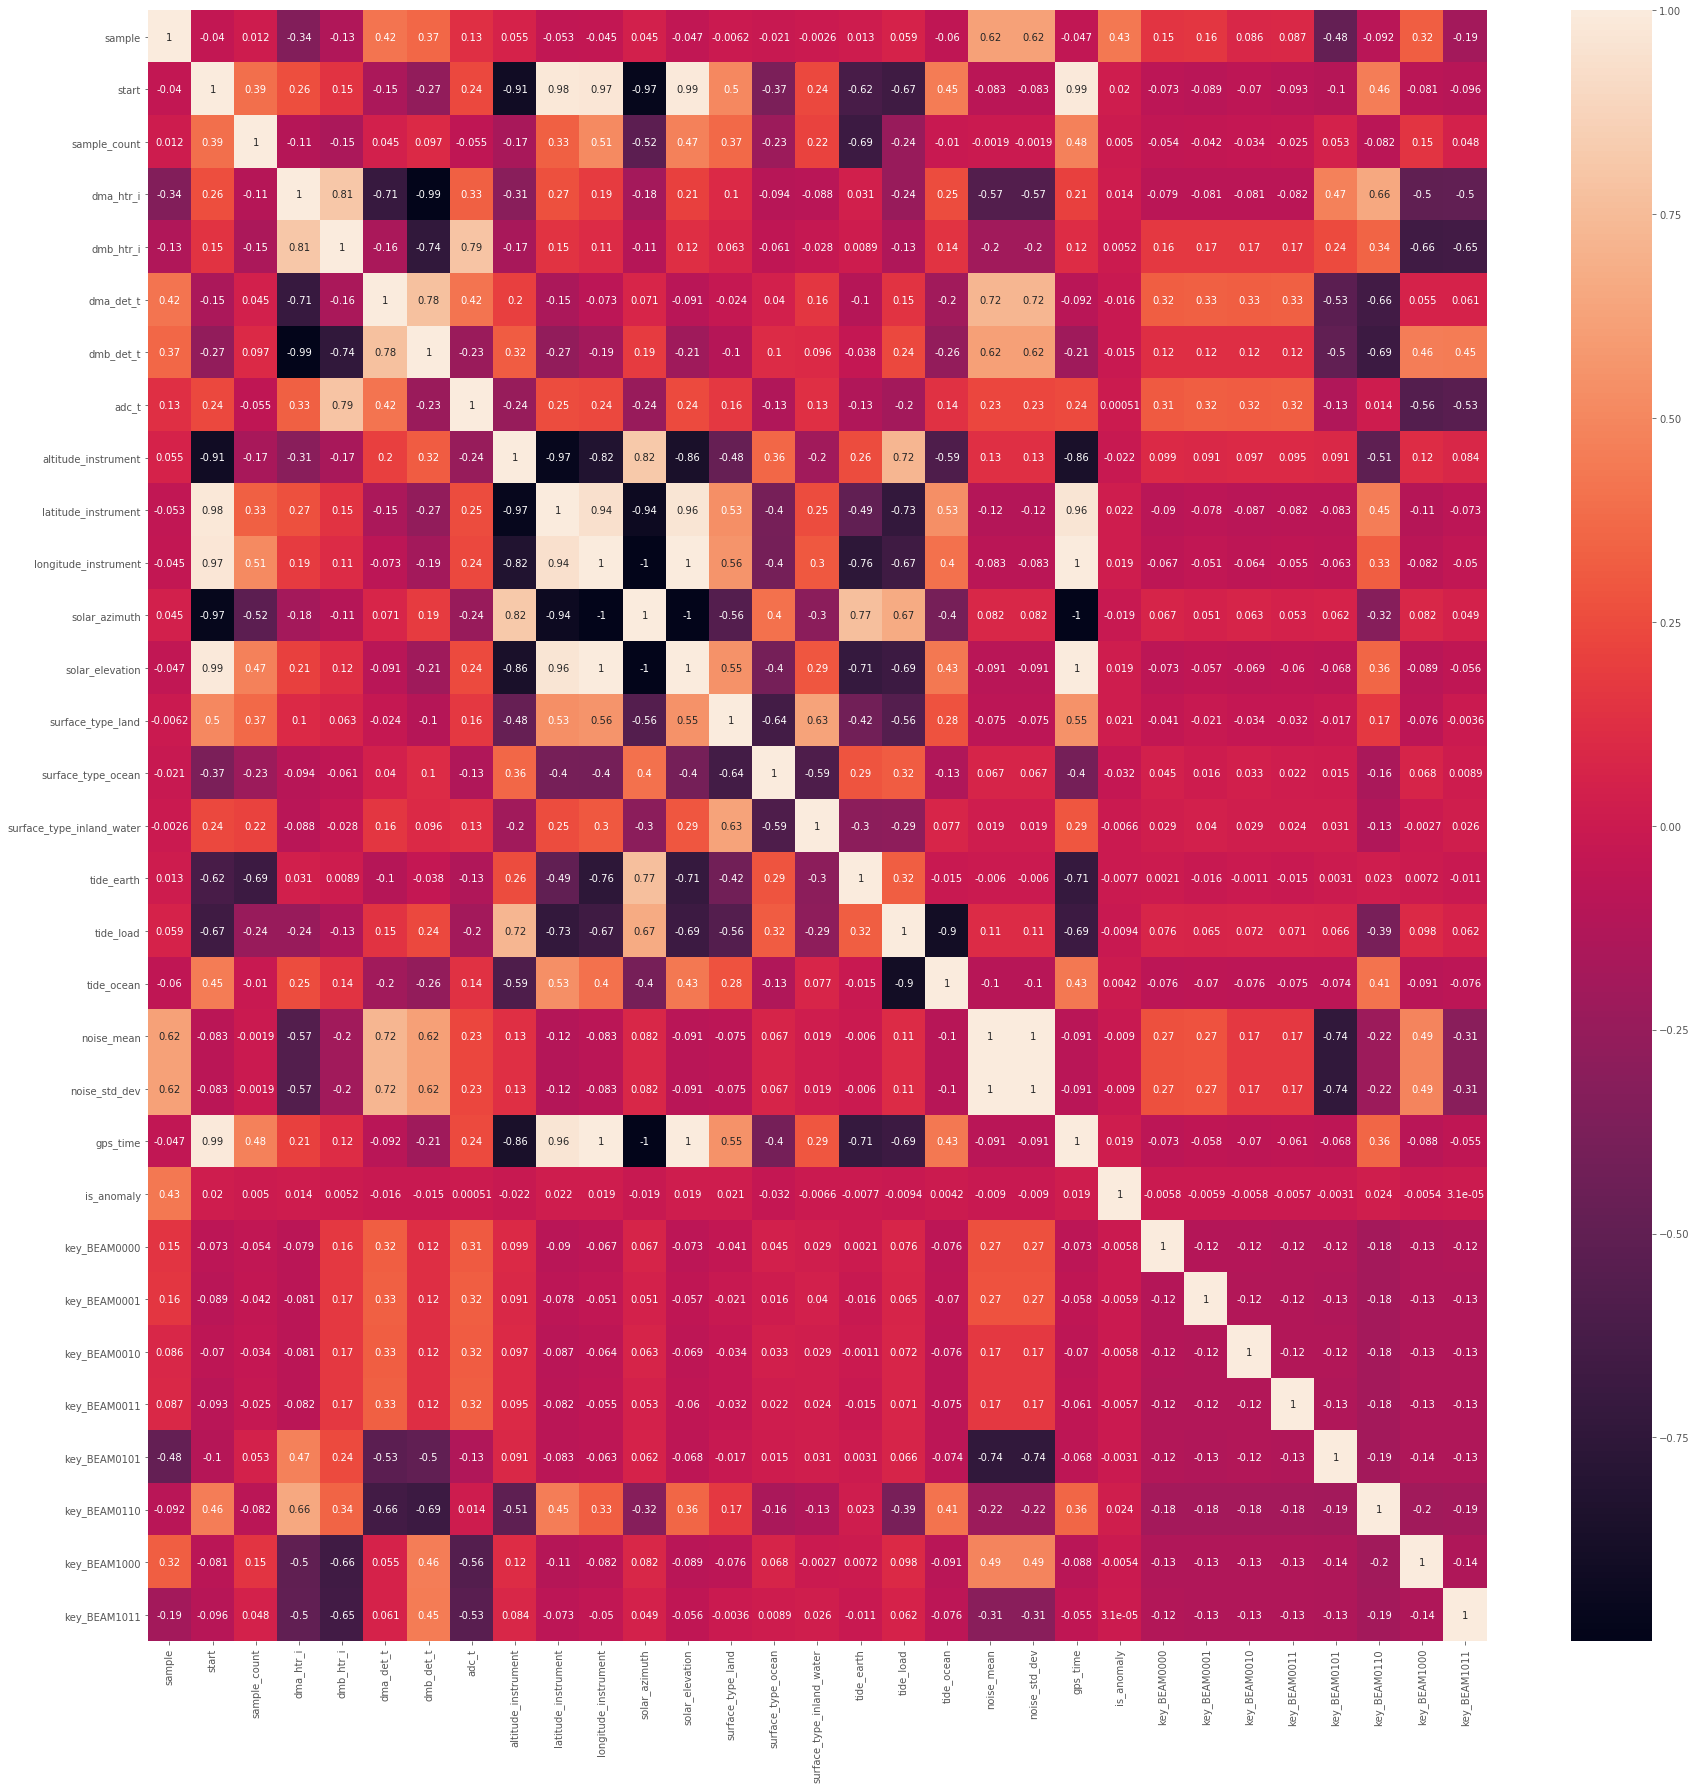

In [226]:
# Correlation Heatmap to determine if any variables are correlated with each other. The majority seem to not be correlated,
# and the ones that are correlated like temperature and altitude make sense in this domain.
corr = dataset.corr()

fig, ax = plt.subplots(figsize=(30,30))
sn.heatmap(corr, annot=True,ax=ax)
plt.show()

<p>Here we can see the latitudes and longitudes of the anomalous data, proving that the anomalies occur around the South Atlantic.</p>
<p><em>The following code was run on Google Colab to produce this map.</em></p>
<br>
<code>from shapely.geometry import Point</code>
<br>
<code>import geopandas as gpd</code>
<br>
<code>from geopandas import GeoDataFrame</code>
<br>
<code>geometry = [Point(xy) for xy in zip(df['longitude_instrument'], df['latitude_instrument'])]</code>
<br>
<code>gdf = GeoDataFrame(df, geometry=geometry)</code>
<br>
<code>world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))</code>
<br>
<code>gdf.plot(ax=world.plot(figsize=(100, 60)), marker='o', color='red', markersize=35)</code>
<br>
<img src='https://i.imgur.com/NnVV99s.png'>

In [227]:
# Now let's see the effective rate using number of events vs effective duty cycle 
# (i.e. how much time we had to look before we saw one)
events = len(dataset['sample'][dataset['is_anomaly'] == 1])

print("Number of events:",events)

print()
duty_cycle = dataset[['gps_time',"is_anomaly","datetime"]]
initial_time = duty_cycle['datetime'].iloc[0]
duty_cycle = dataset[dataset['is_anomaly'] == 1].sort_values(by='gps_time',ascending=True)

print("Initial Datetime\n",initial_time)
print()
print("First Anomaly Occurance\n",duty_cycle['datetime'].iloc[0])

Number of events: 3786

Initial Datetime
 Tue Jul 28 09:00:42 2009

First Anomaly Occurance
 Tue Jul 28 09:06:15 2009


In [228]:
dataset

,sample,start,sample_count,dma_htr_i,dmb_htr_i,dma_det_t,dmb_det_t,adc_t,altitude_instrument,latitude_instrument,...,datetime,is_anomaly,key_BEAM0000,key_BEAM0001,key_BEAM0010,key_BEAM0011,key_BEAM0101,key_BEAM0110,key_BEAM1000,key_BEAM1011
0,247,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
1,244,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
2,239,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
3,242,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
4,245,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
5,243,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
6,247,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
7,248,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
8,248,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0
9,248,25560,101,88.26531,88.23342,66.41389,69.02371,44.71910,429344.72732,-51.79367,...,Tue Jul 28 09:00:42 2009,0,1,0,0,0,0,0,0,0


# Preprocessing

Due to the fact that there are so little anomalous data compared to the non-anomalous data, there exists a class imbalance (as seen in the cell below). Therefore, in order to balance the classes, we must create a new dataset that is undersampled. The undersampling process takes all of the anomalous data and their indicies and concatenates it with an equal amount of randomly selected non-anomalous data. This ultimately creates a new dataset that is balanced and able to be put into a machine learning algorithm. If the data was not balanced and put into the machine learning models, it would be almost entirely trained on non-anomalous data, skewing results and creating false conclusions. Thanks to Bhavesh Bhatt for providing a template which I have adapted to suite this dataset.

Credit: https://github.com/bhattbhavesh91/imbalance_class_sklearn/blob/master/imbalance_class_undersampling_oversampling.ipynb

In [229]:
dataset = dataset.drop("datetime",axis=1)

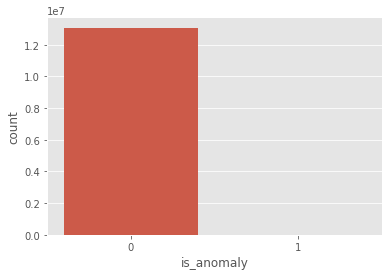

In [230]:
sn.countplot(x="is_anomaly",data=dataset)

In [231]:
minority_class_len = len(dataset['is_anomaly'][dataset['is_anomaly'] == 1])
minority_class_len

3786

In [232]:
majority_class_indicies = dataset['is_anomaly'][dataset['is_anomaly'] == 0].index
majority_class_indicies

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,        7,        8,        9,
            ...
            13075404, 13075405, 13075406, 13075407, 13075408, 13075409,
            13075410, 13075411, 13075412, 13075413],
           dtype='int64', length=13071628)

In [233]:
minority_class_indicies = dataset['is_anomaly'][dataset['is_anomaly'] == 1].index
minority_class_indicies

Int64Index([ 5507565,  5507566,  5507567,  5507568,  5507569,  5507570,
             5507571,  5507572,  5507573,  5507574,
            ...
            13074250, 13074983, 13074984, 13074985, 13074986, 13074987,
            13074988, 13074989, 13074990, 13074991],
           dtype='int64', length=3786)

In [234]:
random_majority_indicies = np.random.choice(majority_class_indicies,minority_class_len,replace=False)
random_majority_indicies

array([11662370,   124562, 10956058, ...,  3806605,  7207791,  5581207],
      dtype=int64)

In [235]:
under_sample_indicies = np.concatenate([minority_class_indicies,random_majority_indicies])
under_sample_indicies

array([5507565, 5507566, 5507567, ..., 3806605, 7207791, 5581207],
      dtype=int64)

In [236]:
under_sample = dataset.loc[under_sample_indicies]
under_sample

,sample,start,sample_count,dma_htr_i,dmb_htr_i,dma_det_t,dmb_det_t,adc_t,altitude_instrument,latitude_instrument,...,gps_time,is_anomaly,key_BEAM0000,key_BEAM0001,key_BEAM0010,key_BEAM0011,key_BEAM0101,key_BEAM0110,key_BEAM1000,key_BEAM1011
5507565,731,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507566,788,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507567,835,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507568,879,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507569,911,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507570,921,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507571,904,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507572,872,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507573,822,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0
5507574,769,59158620,748,88.26531,88.23342,66.82764,69.37381,45.11491,428643.19884,-46.21542,...,1248786393,1,0,0,0,1,0,0,0,0


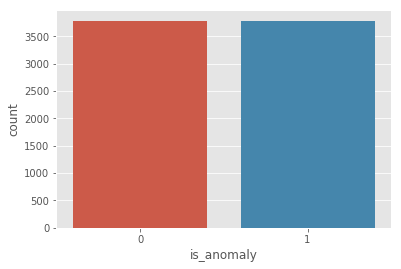

In [237]:
sn.countplot(x="is_anomaly",data=under_sample)

# Split Data and Training

In [238]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass


target = "is_anomaly"
X = under_sample.loc[:, dataset.columns!=target]
Y = under_sample.loc[:, dataset.columns==target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Logistic Regression

In [239]:
lgr_classifier = LogisticRegression()
lgr_classifier.fit(X_train, Y_train)

Y_pred_lgr = lgr.predict(X_test)

generate_model_report(Y_test, Y_pred_lgr)

Accuracy =  0.8795518207282913
Precision =  0.8167539267015707
Recall =  0.983451536643026
F1 Score =  0.8923846978905972


C:\Users\Jake\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# KNN

In [240]:
knn_classifier = KNeighborsClassifier(n_neighbors=6,metric='euclidean')
knn_classifier.fit(X_train,Y_train)

Y_pred_knn = knn_classifier.predict(X_test)

generate_model_report(Y_test, Y_pred_knn)

Accuracy =  0.9563825530212084
Precision =  0.927098674521355
Recall =  0.9921197793538219
F1 Score =  0.9585078035782261


C:\Users\Jake\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


# Random Forest

In [241]:
rf_classifier = RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=0)
rf_classifier.fit(X_train,Y_train)

Y_pred_rf = rf_classifier.predict(X_test)

generate_model_report(Y_test, Y_pred_rf)

C:\Users\Jake\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy =  0.9995998399359743
Precision =  0.9992125984251968
Recall =  1.0
F1 Score =  0.9996061441512406


# Naive Bayes

In [242]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,Y_train)

Y_pred_nb = nb_classifier.predict(X_test)

generate_model_report(Y_test, Y_pred_nb)

Accuracy =  0.9319727891156463
Precision =  0.8894401133947555
Recall =  0.9889676910953507
F1 Score =  0.9365671641791045


C:\Users\Jake\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Results